# Minimal working example comparing SGD, Adagrad, Adam, AdamW

Starting optimizer comparison experiment...
Using device: cpu

Training with SGD...
Epoch 1/20 - 12.02s - Train Loss: 0.6713 - Train Acc: 0.7661 - Val Loss: 0.4916 - Val Acc: 0.8223
Epoch 2/20 - 9.05s - Train Loss: 0.4193 - Train Acc: 0.8478 - Val Loss: 0.4323 - Val Acc: 0.8408
Epoch 3/20 - 6.08s - Train Loss: 0.3772 - Train Acc: 0.8636 - Val Loss: 0.3942 - Val Acc: 0.8549
Epoch 4/20 - 5.68s - Train Loss: 0.3474 - Train Acc: 0.8745 - Val Loss: 0.3917 - Val Acc: 0.8562
Epoch 5/20 - 6.11s - Train Loss: 0.3254 - Train Acc: 0.8805 - Val Loss: 0.3709 - Val Acc: 0.8678
Epoch 6/20 - 6.36s - Train Loss: 0.3085 - Train Acc: 0.8876 - Val Loss: 0.3516 - Val Acc: 0.8736
Epoch 7/20 - 5.98s - Train Loss: 0.2940 - Train Acc: 0.8920 - Val Loss: 0.3554 - Val Acc: 0.8710
Epoch 8/20 - 6.66s - Train Loss: 0.2865 - Train Acc: 0.8941 - Val Loss: 0.3443 - Val Acc: 0.8761
Epoch 9/20 - 8.96s - Train Loss: 0.2709 - Train Acc: 0.9001 - Val Loss: 0.3351 - Val Acc: 0.8808
Epoch 10/20 - 6.08s - Train Loss: 0.2617 -

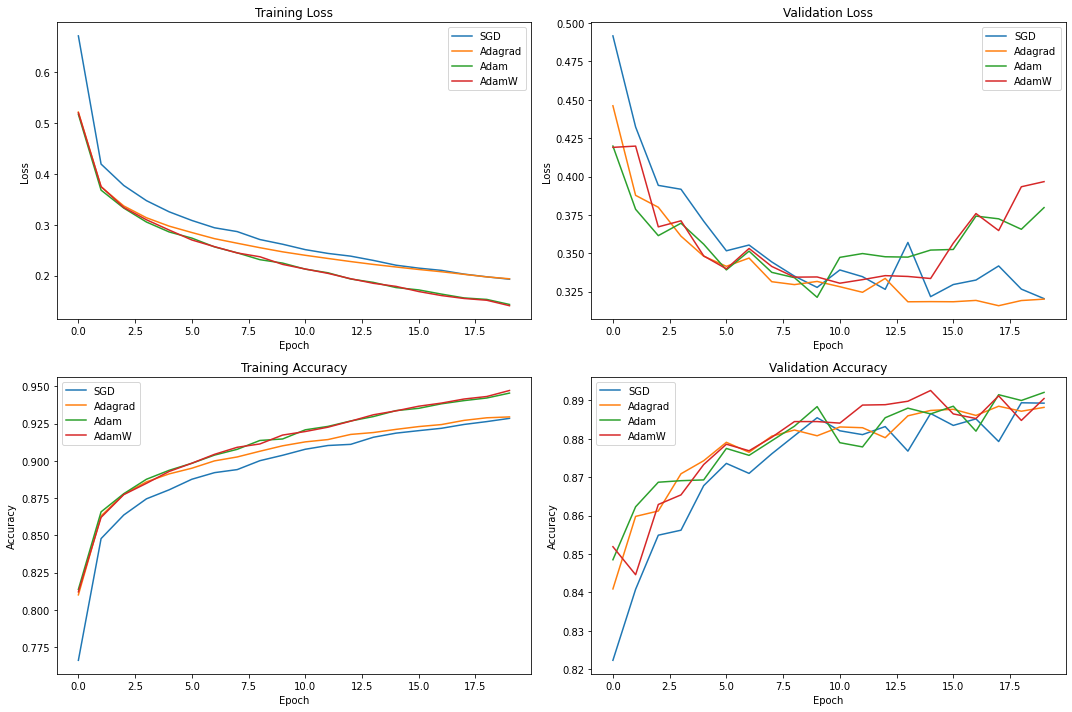

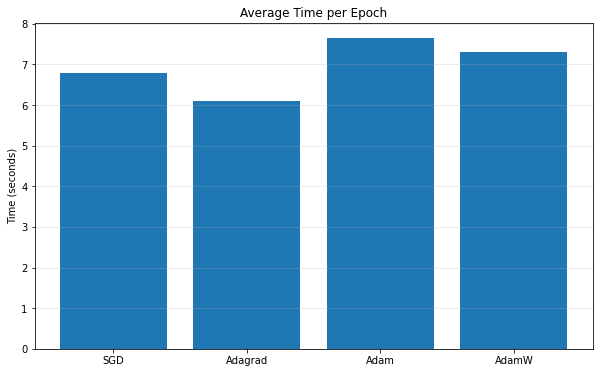

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load Fashion MNIST dataset
def load_fashion_mnist(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_dataset = datasets.FashionMNIST(
        root='./data', 
        train=True, 
        download=True, 
        transform=transform
    )
    
    test_dataset = datasets.FashionMNIST(
        root='./data', 
        train=False, 
        download=True, 
        transform=transform
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False
    )
    
    return train_loader, test_loader

# Function to train the model with a specific optimizer
def train_model(model, optimizer_name, train_loader, test_loader, 
                learning_rate, epochs=10, device='cpu'):
    """
    Train a model with the specified optimizer and return training history.
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Initialize optimizer based on name
    if optimizer_name.lower() == 'sgd':
        optimizer = torch.optim.SGD(
            model.parameters(), 
            lr=learning_rate, 
            momentum=0.9,
            weight_decay=1e-4
        )
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(
            model.parameters(), 
            lr=learning_rate
        )
    elif optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=learning_rate,
            betas=(0.9, 0.999),
            eps=1e-8
        )
    elif optimizer_name.lower() == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=learning_rate,
            betas=(0.9, 0.999),
            weight_decay=1e-4,
            eps=1e-8
        )
    else:
        raise ValueError(f"Optimizer {optimizer_name} not supported")
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'time_per_epoch': []
    }
    
    # Training loop
    for epoch in range(epochs):
        start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = correct / total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(test_loader.dataset)
        val_acc = correct / total
        
        epoch_time = time.time() - start_time
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['time_per_epoch'].append(epoch_time)
        
        print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.2f}s - "
              f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
    
    return history

# Main experiment function
def run_optimizer_comparison():
    print("Starting optimizer comparison experiment...")
    
    # Check for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    train_loader, test_loader = load_fashion_mnist(batch_size=128)
    
    # Define optimizer configurations to test
    optimizer_configs = [
        {'name': 'SGD', 'lr': 0.01},
        {'name': 'Adagrad', 'lr': 0.01},
        {'name': 'Adam', 'lr': 0.001},
        {'name': 'AdamW', 'lr': 0.001}
    ]
    
    all_histories = {}
    
    # Train with each optimizer
    for config in optimizer_configs:
        print(f"\nTraining with {config['name']}...")
        model = SimpleNN()
        
        history = train_model(
            model=model,
            optimizer_name=config['name'],
            train_loader=train_loader,
            test_loader=test_loader,
            learning_rate=config['lr'],
            epochs=20,
            device=device
        )
        
        all_histories[config['name']] = history
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot training loss
    plt.subplot(2, 2, 1)
    for opt_name, history in all_histories.items():
        plt.plot(history['train_loss'], label=f"{opt_name}")
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot validation loss
    plt.subplot(2, 2, 2)
    for opt_name, history in all_histories.items():
        plt.plot(history['val_loss'], label=f"{opt_name}")
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training accuracy
    plt.subplot(2, 2, 3)
    for opt_name, history in all_histories.items():
        plt.plot(history['train_acc'], label=f"{opt_name}")
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(2, 2, 4)
    for opt_name, history in all_histories.items():
        plt.plot(history['val_acc'], label=f"{opt_name}")
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('optimizer_comparison.png')
    
    # Plot time per epoch
    plt.figure(figsize=(10, 6))
    avg_times = {opt: np.mean(hist['time_per_epoch']) for opt, hist in all_histories.items()}
    plt.bar(avg_times.keys(), avg_times.values())
    plt.title('Average Time per Epoch')
    plt.ylabel('Time (seconds)')
    plt.grid(axis='y', alpha=0.3)
    plt.savefig('optimizer_timing.png')
    
    
    print("\nExperiment complete. Results saved as PNG files")

if __name__ == "__main__":
    run_optimizer_comparison()
